# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [3]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=0

In [4]:
data_p = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/{SEED}")


In [5]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [6]:


color_dict = {
    "hdbind-rp-molformer": rocket_color_pal[2]
#     "smiles-pe.atomwise.0": rocket_color_pal[2],
#     "smiles-pe.bpe.0": rocket_color_pal[4],   
# "selfies.atomwise": green_color_pal[4],
#     "ecfp": green_color_pal[6],
#     "rp": green_color_pal[8],
#     "rf": blue_color_pal[4],
#     "mlp": blue_color_pal[7],
#     "HDC-MLP": green_color_pal[9],
#     "HDC-RF": green_color_pal[9],
#     "Vina": "salmon",
}


model_order_list = [
    ("hdbind-rp-molformer", "HDBind+MolFormer")
#     ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
#     ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
#     ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
#     ("ecfp", "HDBind-ECFP"),
#     ("rp", "HDBind-ECFP+RP"),
#     ("rf", "RF"),
#     ("mlp", "MLP"),
#     ("Vina", "Vina")
]


model_name_dict = {
    "hdbind-rp-molformer": "HDBind+MolFormer"
#     "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
#     "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
#     "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
#     "ecfp": "HDBind-ECFP",
#     "rp": "HDBind-RPFP",
#     "rf": "RF",
#     "mlp": "MLP",
#     "Vina": "Vina",
#     "HDC-MLP": "HDC-MLP",
#     "HDC-RF": "HDC-RF"
}

# LIT-PCBA Results

In [7]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true):
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
#            "roc": roc_auc_score(y_score=y_score, y_true=y_true)
           }


def aggregate_results(dataset, range_limit=10, multistep_initial_p=None, 
                      multistep_p_list=None, 
                      multistep_sklearn_model=None):
    

    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
#                          "roc": []
                        }
    tokenizer="atomwise"
    ngram_order=0
    for model, color in tqdm(color_dict.items(), total=len(color_dict), position=0):
                        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        train_size_list = []
        test_size_list = []
        target_size_list = []
        eta_list = []

        
        if model not in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.{model}*pkl"))

        elif model in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.ecfp*pkl"))
        
#     '''

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
            with open(path, "rb") as handle:
                model_data_dict = pickle.load(handle)

            
            target = path.name.split(".")[1]
            
            # just choosing this as a debug case
#             if target not in ["GBA", "ALDH1"]:
#                 continue
            
            print(target, path, model)

            hd_cache_dir = f"/p/lustre2/jones289/hd_cache/125/ecfp/{dataset}/random"

            for seed in range(range_limit):
                                
                    
#                 DEBUG_SIZE=100  
#                 y_test = model_data_dict["y_test"][:DEBUG_SIZE]
#                 x_test = model_data_dict["x_test"][:DEBUG_SIZE]
                y_test = model_data_dict["y_test"]
                x_test = model_data_dict["x_test"]
                actives_database = sum(y_test)
                database_size = y_test.shape[0]
                
                eta = None 
                

                if model in ["rf", "mlp"]:


                    for p in [.01, .1]:

                        sklearn_model = model_data_dict[seed]["model"]

                        y_score = sklearn_model.predict_proba(x_test)[:, 1]            
                        y_pred = sklearn_model.predict(x_test)
                        enrich = compute_enrichment_factor(sample_scores=y_score, 
                                                sample_labels=y_test,
                                                n_percent=p, 
                                                actives_database=actives_database, 
                                                database_size=database_size)

                
                        metrics = compute_metrics(y_pred=y_pred, y_score=y_score, y_true=y_test)
                
                        model_metric_dict["model"].append(model)
                        model_metric_dict["target"].append(target)
                        model_metric_dict["enrich"].append(enrich)
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
#                         model_metric_dict["roc"].append(metrics["roc"])

                        
                elif model.lower() in ["hdc-rf", "hdc-mlp"]:

                    sklearn_result_file = Path(f"{data_p}/{dataset.replace('-', '_')}.{target}.{multistep_sklearn_model}.None.{ngram_order}.pkl")

                    with open(sklearn_result_file, "rb") as handle:
                        sklearn_result_dict = pickle.load(handle)

                    target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"

                    hv_test = torch.load(target_test_hv_path, map_location="cpu")
                    hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)

#                     # filter the data
                    idxs = np.flip(np.argsort(hdc_conf_scores.squeeze().cpu().numpy(), kind="stable"))

                    
                    sample_n = int(multistep_initial_p * y_test.shape[0])
                    samp_idxs = idxs[:sample_n]
                    

                    x_test_samp = x_test[samp_idxs]
                    y_test_samp = y_test[samp_idxs]
                                            
    
                    for p in multistep_p_list:

                        sklearn_model = sklearn_result_dict[seed]["model"]
            
                        sklearn_scores_samp = sklearn_model.predict_proba(x_test_samp)[:, 1]                        
            
                        y_pred = sklearn_model.predict(x_test_samp)
                        enrich = compute_enrichment_factor(sample_scores=sklearn_scores_samp, 
                                                sample_labels=y_test_samp,
                                                n_percent=p, 
                                                actives_database=actives_database, 
                                                database_size=database_size)


                        metrics = compute_metrics(y_pred=y_pred, y_score=sklearn_scores_samp, y_true=y_test_samp)
                
                        model_metric_dict["model"].append(model)
                        model_metric_dict["target"].append(target)
                        model_metric_dict["enrich"].append(enrich)
                        model_metric_dict["p"].append(round(multistep_initial_p * p, 2))
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
#                         model_metric_dict["roc"].append(metrics["roc"])
                    

                else:                  
                    
                    target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"
                
                    hv_test = torch.load(target_test_hv_path, map_location="cpu")
                    hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)
                    
                    for p in [.01, .1]:

                        enrich = compute_enrichment_factor(sample_scores=hdc_conf_scores, 
                                                sample_labels=y_test,
                                                n_percent=p, 
                                                actives_database=actives_database, 
                                                database_size=database_size)
                        y_pred = model_data_dict[seed]["y_pred"]
                        metrics = compute_metrics(y_pred=y_pred, y_score=hdc_conf_scores, y_true=y_test)
                
                        model_metric_dict["model"].append(model)
                        model_metric_dict["target"].append(target)
                        model_metric_dict["enrich"].append(enrich)
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
#                         model_metric_dict["roc"].append(metrics["roc"])

                #TODO: implement this 
#                 model_metric_dict["train_time"].append(train_time)
#                 model_metric_dict["test_time"].append(test_time)

    return model_metric_dict
        


# VINA result

In [9]:
from pathlib import Path
def docking_main(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

    path_list = [path for path in root_p.glob("*-actives.csv")]


    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
    return df

In [10]:
def compute_model_metric_df():
    model_metric_dict = aggregate_results(dataset="lit-pcba",multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)

    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

    # model_metric_df

    #######
    vina_result = docking_main(nrows=None)
    vina_result
    ###########

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
    vina_col=' scores/1'
    for target, target_df in vina_result.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(sample_scores=np.abs(target_df[vina_col]), 
                                      sample_labels=target_df["y_true"], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)


    ##################
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
    model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
    return model_metric_df    


In [11]:
from pathlib import Path
model_metric_df_path = Path("fixed_litpcba_model_metric_df.csv")
model_metric_df = None
if model_metric_df_path.exists():
    print(f"{model_metric_df_path} exists! reading it now...")
    model_metric_df = pd.read_csv(model_metric_df_path, index_col=0)
    print("done.")
    
else:
    print(f"{model_metric_df_path} does not exist..computing it now..")
    model_metric_df = compute_model_metric_df()
    print("done.")

fixed_litpcba_model_metric_df.csv exists! reading it now...
done.


In [12]:
model_metric_df["model"]

0     smiles-pe.atomwise.0
1     smiles-pe.atomwise.0
2     smiles-pe.atomwise.0
3     smiles-pe.atomwise.0
4     smiles-pe.atomwise.0
              ...         
25                    Vina
26                    Vina
27                    Vina
28                    Vina
29                    Vina
Name: model, Length: 2160, dtype: object

In [13]:
# enrich_1_df.groupby(['model','target', 'p']).describe().to_csv("summary_ef_stats_1.csv")
(model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")
# enrich_10_df.groupby(['model', 'target', 'p']).describe().to_csv("summary_ef_stats_10.csv")

In [14]:
def make_box_plot(enrich_1_df, enrich_10_df):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.boxplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
    sns.boxplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
    labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich.png", dpi=600, bbox_inches="tight")

#     return enrich_f

In [15]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()


In [16]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
1,HDC-RF,ADRB2,0.1,0.000000
3,HDC-RF,ALDH1,0.1,1.584438
5,HDC-RF,ESR1_ago,0.1,2.997857
7,HDC-RF,ESR1_ant,0.1,3.084249
9,HDC-RF,FEN1,0.1,2.467475
...,...,...,...,...
231,smiles-pe.bpe.0,OPRK1,0.1,3.333333
233,smiles-pe.bpe.0,PKM2,0.1,0.875884
235,smiles-pe.bpe.0,PPARG,0.1,0.000000
237,smiles-pe.bpe.0,TP53,0.1,2.977570


In [17]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,HDC-RF,ADRB2,0.01,0.000000
2,HDC-RF,ALDH1,0.01,8.043328
4,HDC-RF,ESR1_ago,0.01,3.330952
6,HDC-RF,ESR1_ant,0.01,22.793787
8,HDC-RF,FEN1,0.01,19.987191
...,...,...,...,...
230,smiles-pe.bpe.0,OPRK1,0.01,0.000000
232,smiles-pe.bpe.0,PKM2,0.01,1.457911
234,smiles-pe.bpe.0,PPARG,0.01,0.000000
236,smiles-pe.bpe.0,TP53,0.01,4.827273


KeyError: 'HDC-RF'

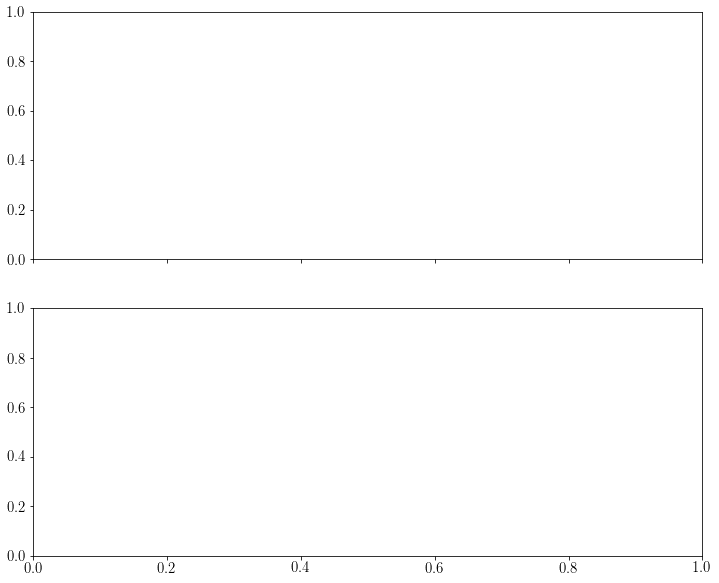

In [18]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

In [ ]:
def make_swarm_plot(enrich_1_df, enrich_10_df):

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
    labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich-swarm.png", dpi=600, bbox_inches="tight")

#     return enrich_f

In [ ]:
make_swarm_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

In [ ]:
grp_df

In [ ]:
from pandas.plotting import parallel_coordinates

def make_pc_plot(df):

#     f, ax = plt.subplots(1,1, figsize=(12,10), sharex=True, sharey=False)

    df_list = list(df.groupby(["model"]))
    print(df_list)
#     pc_df = pd.concat([group_df for group_name, group_df in df.groupby('model')], axis=1)

    

#     ax = ax.flatten()
#     enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
#     sns.swarmplot(data=model_1_df, x="model", y="enrich", ax=ax, palette=color_dict)
#     enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
#     enrich_1_ax.set_xlabel("")
#     enrich_1_ax.set_ylabel("")
#     enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

#     enrich_1_ax.set_ylabel("EF")

#     plt.tight_layout()

    
#     sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
#     enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
#     enrich_10_ax.set_xlabel("")
#     enrich_10_ax.set_ylabel("")
#     enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
#     labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
#     labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
#     enrich_10_ax.set_xticklabels(labels)
#     enrich_ax[0].set_ylabel("EF")
#     enrich_ax[1].set_ylabel("EF")

#     plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
#     enrich_f.savefig("lit-pcba-enrich-swarm.png", dpi=600, bbox_inches="tight")

#     return enrich_f
make_pc_plot(grp_df[grp_df["model"].apply(lambda x: x in  ["HDC-RF", "rf", "ecfp"])])

# Speedup

In [ ]:
def aggregate_time_results(dataset, range_limit=10):
    

    model_time_dict = {"model": [], "target": [], "seed": [],"train_time": [], "test_time": [], "train_size": [], "test_size": []}
    
    
    tokenizer="atomwise"
    ngram_order=0
    for model, color in tqdm(color_dict.items(), total=len(color_dict), position=0):
                        
        metric_list = []
        test_time_list = []
        train_size_list = []
        test_size_list = []
        target_size_list = []
        eta_list = []

        
        if model not in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.{model}*pkl"))

        elif model in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.ecfp*pkl"))
    
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
            with open(path, "rb") as handle:
                model_data_dict = pickle.load(handle)

            
            target = path.name.split(".")[1]
            
            tqdm.write(f"{target}, {path}, {model}")

            hd_cache_dir = f"/p/lustre2/jones289/hd_cache/125/ecfp/{dataset}/random"

            for seed in range(range_limit):
                    
                model_time_dict["model"].append(model)
                model_time_dict["target"].append(target)
                model_time_dict["seed"].append(seed)
                model_time_dict["train_time"].append(model_data_dict[seed]["train_time"])
                model_time_dict["test_time"].append(model_data_dict[seed]["test_time"])
                model_time_dict["train_size"].append(model_data_dict[seed]["train_size"])
                model_time_dict["test_size"].append(model_data_dict[seed]["test_size"])

                



    return model_time_dict
        


In [ ]:
time_dict = aggregate_time_results(dataset="lit-pcba", range_limit=10)
time_df = pd.DataFrame(time_dict)

In [ ]:
time_df["test_latency"] = time_df.apply(lambda x: x["test_time"]/x["test_size"], axis=1)

## averaging over seeds

In [ ]:
time_df.groupby(["model", "target"])["test_latency"].mean().reset_index()

## averaging over both seeds and target dimensions

In [ ]:
time_df.groupby(["model", "target"])["test_latency"].mean().reset_index().groupby("model")["test_latency"].median().reset_index()

In [ ]:
sns.boxplot(x="model", y="test_latency", data=time_df.groupby(["model", "target"])["test_latency"].mean().reset_index())